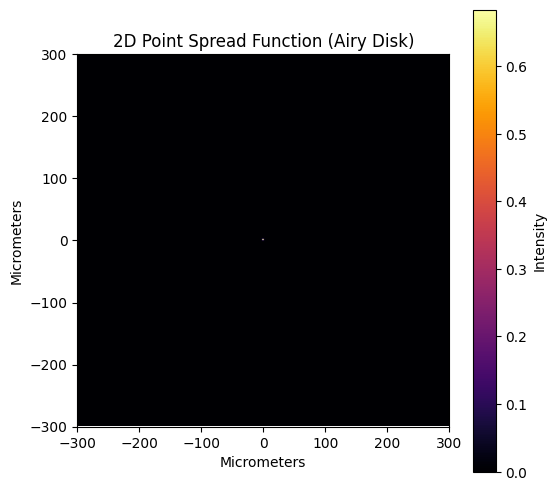

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1

# Telescope parameters
wavelength = 550e-9      # 550 nm
aperture_diameter = 0.15 # 15 cm telescope

# 2D PSF (Airy Disk) Generator
def airy_psf_2d(N=500, pixel_scale=1e-6):
    """
    N           = size of the image (NxN)
    pixel_scale = meters per pixel
    """
    # Create grid
    x = np.linspace(-N/2, N/2, N) * pixel_scale
    y = np.linspace(-N/2, N/2, N) * pixel_scale
    X, Y = np.meshgrid(x, y)
    
    # Radial distance from center
    R = np.sqrt(X**2 + Y**2)

    # Convert to wave number expression
    k = 2 * np.pi / wavelength
    x_val = k * aperture_diameter * R

    # Compute intensity using Airy function
    intensity = np.where(
        x_val == 0,
        1.0,
        (2 * j1(x_val) / x_val)**2
    )

    return intensity

# Generate PSF
psf = airy_psf_2d(N=600, pixel_scale=1e-6)

# Display it
plt.figure(figsize=(6,6))
plt.imshow(psf, cmap='inferno', extent=[-300,300,-300,300])
plt.colorbar(label="Intensity")
plt.title("2D Point Spread Function (Airy Disk)")
plt.xlabel("Micrometers")
plt.ylabel("Micrometers")
plt.show()


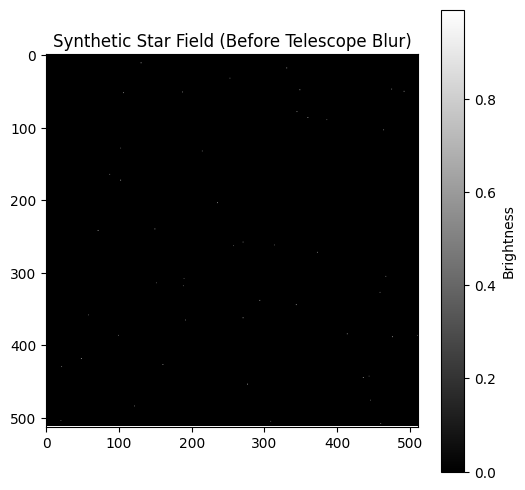

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Generate a Synthetic Star Field
# -----------------------------

# Image size (pixels)
img_size = 512

# Number of stars
num_stars = 50

# Create empty sky image
sky = np.zeros((img_size, img_size))

# Random star positions
np.random.seed(42)
xs = np.random.randint(0, img_size, num_stars)
ys = np.random.randint(0, img_size, num_stars)

# Random star brightness
brightness = np.random.uniform(0.5, 1.0, num_stars)

# Place stars on sky
for x, y, b in zip(xs, ys, brightness):
    sky[y, x] = b

# Display star field
plt.figure(figsize=(6,6))
plt.imshow(sky, cmap="gray")
plt.colorbar(label="Brightness")
plt.title("Synthetic Star Field (Before Telescope Blur)")
plt.show()


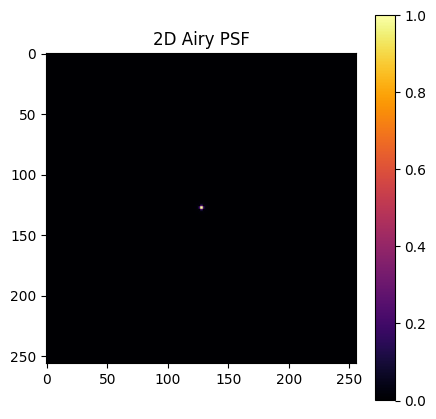

In [12]:
import numpy as np
from scipy.special import j1
import matplotlib.pyplot as plt

def airy_psf_2d(size, wavelength, aperture):
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)

    k = 2 * np.pi / wavelength
    x_arg = k * aperture * r

    # Use j1 from scipy
    psf = (2 * np.nan_to_num(np.where(x_arg != 0, j1(x_arg) / x_arg, 1)))**2
    return psf / np.max(psf)

psf = airy_psf_2d(256, 550e-9, 0.2)

plt.figure(figsize=(5,5))
plt.imshow(psf, cmap='inferno')
plt.colorbar()
plt.title("2D Airy PSF")
plt.show()

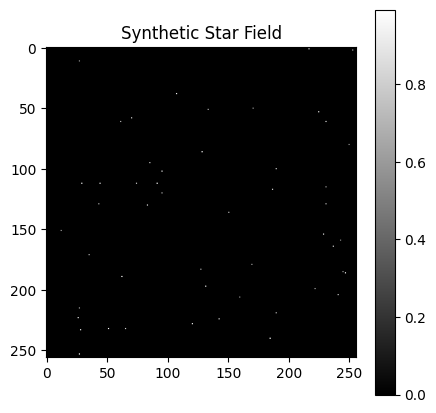

In [13]:
def create_star_field(size, num_stars):
    field = np.zeros((size, size))
    xs = np.random.randint(0, size, num_stars)
    ys = np.random.randint(0, size, num_stars)
    for x, y in zip(xs, ys):
        field[y, x] = np.random.uniform(0.5, 1.0)
    return field

star_field = create_star_field(256, 50)

plt.figure(figsize=(5,5))
plt.imshow(star_field, cmap='gray')
plt.colorbar()
plt.title("Synthetic Star Field")
plt.show()


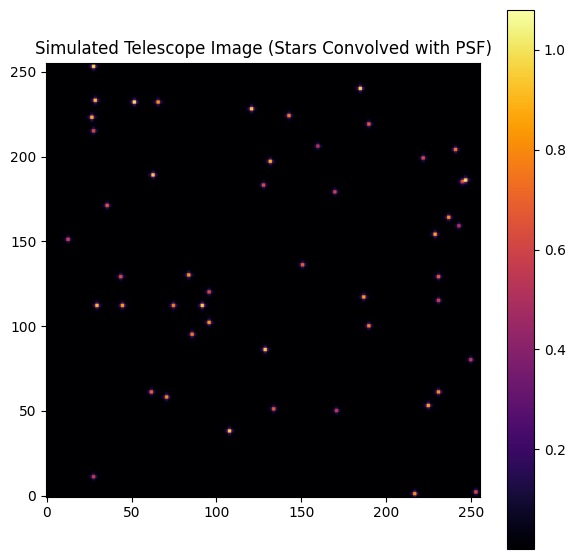

In [14]:
import numpy as np
from scipy.signal import fftconvolve
import matplotlib.pyplot as plt

# PSF from previous step (make sure psf is in memory)
# star_field from previous step too

# Convolution (simulate telescope imaging)
blurred = fftconvolve(star_field, psf, mode='same')

plt.figure(figsize=(7,7))
plt.imshow(blurred, cmap='inferno', origin='lower')
plt.colorbar()
plt.title("Simulated Telescope Image (Stars Convolved with PSF)")
plt.show()


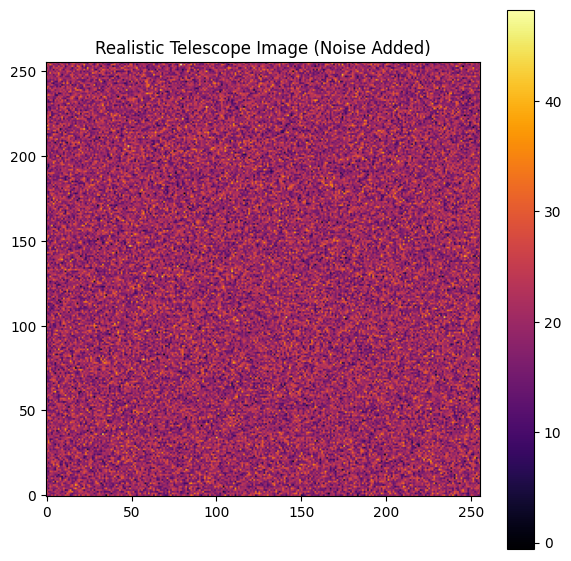

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Use your blurred image from previous step
image = blurred.copy()

# 1) Sky background (constant glow)
sky_background = 20  
image_with_background = image + sky_background

# 2) Photon noise (Poisson)
photon_noisy = np.random.poisson(image_with_background)

# 3) Read noise (Gaussian)
read_noise = np.random.normal(0, 3, image.shape)  # mean=0, std=3 electrons
final_image = photon_noisy + read_noise

plt.figure(figsize=(7,7))
plt.imshow(final_image, cmap='inferno', origin='lower')
plt.colorbar()
plt.title("Realistic Telescope Image (Noise Added)")
plt.show()


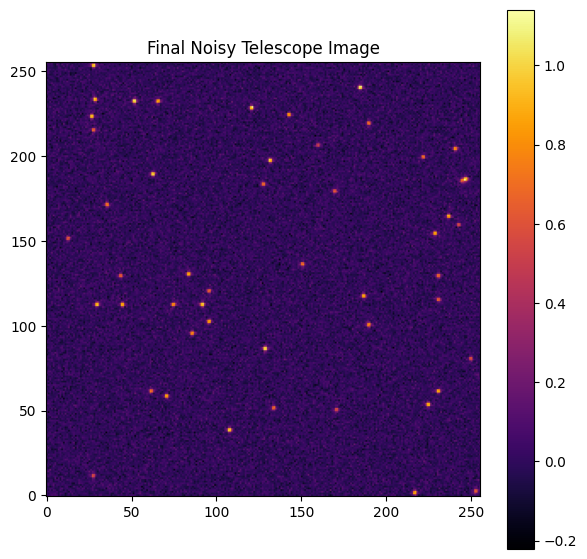

In [16]:
# Add Gaussian noise
noise = np.random.normal(loc=0, scale=0.05, size=blurred.shape)
noisy_image = blurred + noise

plt.figure(figsize=(7,7))
plt.imshow(noisy_image, cmap='inferno', origin='lower')
plt.colorbar()
plt.title("Final Noisy Telescope Image")
plt.show()


In [17]:
from astropy.io import fits

fits.writeto("simulated_telescope_image.fits", noisy_image, overwrite=True)
print("FITS file saved!")

FITS file saved!


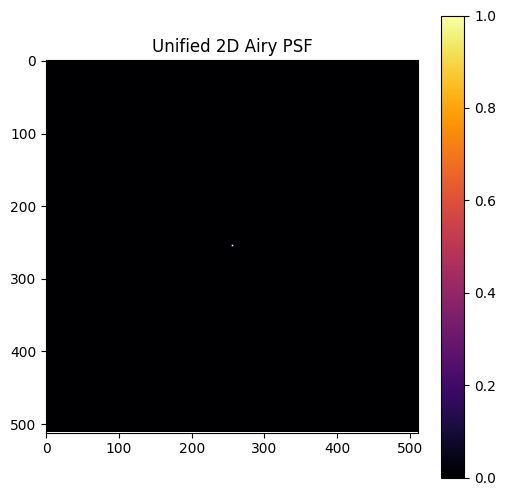

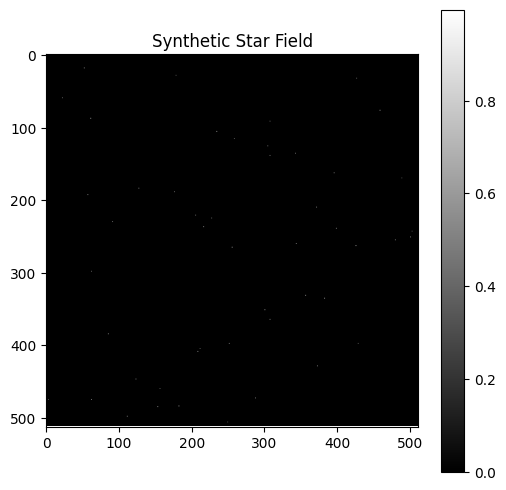

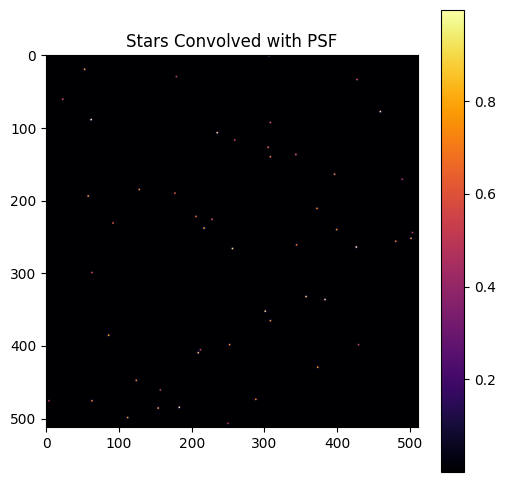

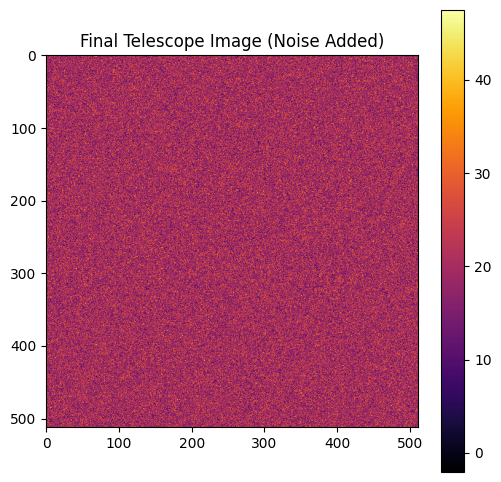

Saved as telescope_simulated_image.fits


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1
from scipy.signal import fftconvolve
from astropy.io import fits

# ---------------------------------------------------------
# PARAMETERS
# ---------------------------------------------------------

wavelength = 550e-9        # meters
aperture_diameter = 0.15   # meters
img_size = 512             # image size
pixel_scale = 1e-6         # meters/pixel
num_stars = 50             # number of synthetic stars

# ---------------------------------------------------------
# 1) 2D Airy PSF
# ---------------------------------------------------------

def airy_psf_2d(N, wavelength, aperture, pixel_scale):
    x = np.linspace(-N/2, N/2, N) * pixel_scale
    y = np.linspace(-N/2, N/2, N) * pixel_scale
    X, Y = np.meshgrid(x, y)

    R = np.sqrt(X**2 + Y**2)
    k = 2 * np.pi / wavelength
    arg = k * aperture * R

    psf = np.where(arg == 0, 1.0, (2 * j1(arg) / arg)**2)
    psf /= np.max(psf)
    return psf

psf = airy_psf_2d(img_size, wavelength, aperture_diameter, pixel_scale)

plt.figure(figsize=(6,6))
plt.imshow(psf, cmap="inferno")
plt.colorbar()
plt.title("Unified 2D Airy PSF")
plt.show()

# ---------------------------------------------------------
# 2) Synthetic star field
# ---------------------------------------------------------

def create_star_field(size, num_stars):
    field = np.zeros((size, size))
    xs = np.random.randint(0, size, num_stars)
    ys = np.random.randint(0, size, num_stars)

    for x, y in zip(xs, ys):
        field[y, x] = np.random.uniform(0.5, 1.0)
    return field

star_field = create_star_field(img_size, num_stars)

plt.figure(figsize=(6,6))
plt.imshow(star_field, cmap="gray")
plt.title("Synthetic Star Field")
plt.colorbar()
plt.show()

# ---------------------------------------------------------
# 3) Convolution → telescope imaging
# ---------------------------------------------------------

blurred = fftconvolve(star_field, psf, mode="same")

plt.figure(figsize=(6,6))
plt.imshow(blurred, cmap="inferno")
plt.title("Stars Convolved with PSF")
plt.colorbar()
plt.show()

# ---------------------------------------------------------
# 4) Add realistic noise
# ---------------------------------------------------------

sky_background = 20
image_with_background = blurred + sky_background

photon_noise = np.random.poisson(image_with_background)
read_noise = np.random.normal(0, 3, blurred.shape)

final_image = photon_noise + read_noise

plt.figure(figsize=(6,6))
plt.imshow(final_image, cmap="inferno")
plt.title("Final Telescope Image (Noise Added)")
plt.colorbar()
plt.show()

# ---------------------------------------------------------
# 5) Save result as FITS
# ---------------------------------------------------------

fits.writeto("telescope_simulated_image.fits", final_image, overwrite=True)
print("Saved as telescope_simulated_image.fits")
